# Download model, spectra and annotations

In [1]:
import requests
import os

from matchms import Scores
from sympy.codegen.ast import continue_
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))

    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size

model_file_name = "ms2deepscore_model.pt"
case_study_spectra_file_name = "case_study_spectra.mgf"
ms2query_annotations_file_name = "ms2query_annotations.csv"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/14535374/files/cleaned_spectra_pos_neg_with_numbering.mgf?download=1", case_study_spectra_file_name)
download_file("https://zenodo.org/records/14535374/files/ms2query_annotations.csv?download=1", ms2query_annotations_file_name)


The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file ms2deepscore_model.pt already exists, the file won't be downloaded
The file case_study_spectra.mgf already exists, the file won't be downloaded
The file ms2query_annotations.csv already exists, the file won't be downloaded


# Load ms2deepscore model

In [2]:
from ms2deepscore.models import load_model
model = load_model(model_file_name)

C:\Users\jonge094\PycharmProjects\ms2deepscore\ms2deepscore\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(f

# Load spectra
The spectra are preprocessed in the notebook pre_processing_spectra.ipynb

In [10]:
from matchms.Pipeline import Pipeline, create_workflow
from ms2deepscore import MS2DeepScore

workflow = create_workflow(
    query_filters=[],
    score_computations=[
        [MS2DeepScore, {"model": model}],
        ],
)
pipeline = Pipeline(workflow)
report = pipeline.run(case_study_spectra_file_name)

2025-07-02 11:50:20,858:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.
2025-07-02 11:50:20,863:WARNING:matchms:SpectrumProcessor:No filters have been specified, so spectra were not filtered


Processing spectra: 2909it [00:02, 1150.43it/s]
2909it [01:10, 41.04it/s]


In [11]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key="query_spectrum_nr",
    score_cutoff=0.85,  # higher numbers produce more isolated sub-graphs
    max_links=10,  # lower number makes sparser networks
    link_method="mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(pipeline.scores, score_name="MS2DeepScore")

In [12]:
filtered_edges = [
    (u, v)
    for u, v in ms2ds_network.graph.edges()
    if (u.startswith("pos") and v.startswith("neg")) or (u.startswith("neg") and v.startswith("pos"))
]

In [13]:
filtered_edges

[('pos_334', 'neg_144'),
 ('pos_498', 'neg_1067'),
 ('neg_1076', 'pos_499'),
 ('neg_1076', 'pos_1296'),
 ('pos_173', 'neg_316'),
 ('pos_173', 'neg_157'),
 ('pos_173', 'neg_366'),
 ('neg_157', 'pos_113'),
 ('neg_157', 'pos_910'),
 ('neg_157', 'pos_970'),
 ('pos_398', 'neg_343'),
 ('pos_398', 'neg_111'),
 ('pos_99', 'neg_771'),
 ('pos_1131', 'neg_144'),
 ('pos_1195', 'neg_343'),
 ('pos_1195', 'neg_111'),
 ('pos_910', 'neg_316'),
 ('pos_910', 'neg_366'),
 ('pos_896', 'neg_771'),
 ('pos_113', 'neg_316'),
 ('pos_113', 'neg_366'),
 ('pos_401', 'neg_380'),
 ('pos_401', 'neg_316'),
 ('pos_1198', 'neg_380'),
 ('pos_1198', 'neg_316'),
 ('pos_1104', 'neg_771'),
 ('neg_834', 'pos_1363'),
 ('neg_834', 'pos_566'),
 ('neg_316', 'pos_970'),
 ('pos_970', 'neg_366'),
 ('neg_771', 'pos_307'),
 ('pos_1295', 'neg_1067')]

In [5]:
from matchms.importing import load_from_mgf

spectra = list(load_from_mgf(case_study_spectra_file_name))

In [14]:
import pandas as pd

manual_annotations = pd.read_csv("Manual_annotations.csv", index_col=0, sep=";")
manual_annotations

,m/z,"RT, min",...,Method of confirmation,Cluster number
Spectrum number,,,,,
neg_157,"181,0379","1,83",...,Confirmed with in-house standard,1
neg_316,"181,0366","1,82",...,Confirmed with in-house standard,1
neg_366,"181,0385","1,83",...,Confirmed with in-house standard,1
neg_380,"195,0569","2,29",...,Comparison to NIST 23 (2023) mass spectral lib...,1
neg_536,"195,0524","2,61",...,Confirmed with in-house standard,1
neg_83,"195,0525","2,29",...,Comparison to NIST 23 (2023) mass spectral lib...,1
pos_1129,"181,0727","2,86",...,Confirmed with in-house standard,1
pos_113,"181,0725","1,11",...,Comparison to NIST 23 (2023) mass spectral lib...,1
pos_1198,"195,091","3,61",...,Confirmed with in-house standard,1


In [15]:
spectrum_pairs_with_manual_annotation = []
for spectrum_ids in filtered_edges:
    if spectrum_ids[0] in manual_annotations.index and spectrum_ids[1] in manual_annotations.index:
        spectrum_pairs_with_manual_annotation.append(spectrum_ids)
spectrum_pairs_with_manual_annotation

[('pos_334', 'neg_144'),
 ('pos_173', 'neg_316'),
 ('pos_173', 'neg_157'),
 ('pos_173', 'neg_366'),
 ('neg_157', 'pos_113'),
 ('neg_157', 'pos_910'),
 ('neg_157', 'pos_970'),
 ('pos_1131', 'neg_144'),
 ('pos_910', 'neg_316'),
 ('pos_910', 'neg_366'),
 ('pos_113', 'neg_316'),
 ('pos_113', 'neg_366'),
 ('pos_401', 'neg_380'),
 ('pos_401', 'neg_316'),
 ('pos_1198', 'neg_380'),
 ('pos_1198', 'neg_316'),
 ('neg_834', 'pos_1363'),
 ('neg_834', 'pos_566'),
 ('neg_316', 'pos_970'),
 ('pos_970', 'neg_366')]

In [16]:
from ms2deepscore import MS2DeepScore
ms2ds_model = MS2DeepScore(model)


In [17]:
from matchms.plotting.spectrum_plots import plot_spectra_mirror
from rdkit import Chem
from rdkit.Chem import Draw
import matchms.similarity as mssim

def plot_mirror_plot_with_structures(spectrum_ids, ax):
    for spectrum_id in spectrum_ids:
        if spectrum_id[:3] == "pos":
            spectrum_id_pos = spectrum_id
        else:
            spectrum_id_neg = spectrum_id

    pos_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_pos][0]
    neg_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_neg][0]

    pos_spectrum.set("compound_name", "")
    neg_spectrum.set("compound_name", "")
    ax = plot_spectra_mirror(pos_spectrum, neg_spectrum, grid=False,
                              ax=ax,
                              # max_mz=420,
                              color_top = "#C6DBEF",
                              color_bottom="#FCBBA1"
                             )

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    smiles_pos = select_smiles(spectrum_id_pos)
    if smiles_pos:
        smiles_img_pos = Draw.MolToImage(Chem.MolFromSmiles(smiles_pos), size=(600, 600))
        ax.imshow(smiles_img_pos, aspect='auto', extent=[xmax - (xmax - xmin) * 0.25,
                                                 xmax - (xmax - xmin) * 0.05,
                                                 ymax * 0.5,
                                                 ymax * 0.9], zorder=10)
    smiles_neg = select_smiles(spectrum_id_neg)
    if smiles_neg:
        smiles_img_neg = Draw.MolToImage(Chem.MolFromSmiles(smiles_neg), size=(600, 600))
        ax.imshow(smiles_img_neg, aspect='auto', extent=[xmax - (xmax - xmin) * 0.25,
                                                         xmax - (xmax - xmin) * 0.05,
                                                         ymin * 0.9,
                                                         ymin * 0.5,], zorder=10)

    similarity_cosine = mssim.CosineGreedy(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    similarity_modified_cosine = mssim.ModifiedCosine(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    ms2deepscore_score = ms2ds_model.pair(pos_spectrum, neg_spectrum)
    ax.text(xmax - (xmax - xmin) * 0.98, 0.9, f"MS2Deepscore: {ms2deepscore_score:.3f}\n"
            f"Cosine score: {similarity_cosine['score']:.3f}\n"
            f"Modified cosine score: {similarity_modified_cosine['score']:.3f}", fontsize=6)
    ax.set_title(None)
    return ax

In [18]:
import matplotlib.pyplot as plt
import math

def plot_grid_of_plots(spectrum_ids, cols=4, ):
    # Example: how many plots?
    n = len(spectrum_ids)

    rows = math.ceil(n / cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Loop through your spectrum IDs and corresponding axes
    for i, spectrum_ids in enumerate(spectrum_ids):
        ax = axes[i]
        plot_mirror_plot_with_structures(spectrum_ids, ax)

    # Turn off unused subplots, if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # djust spacing
    plt.tight_layout()



In [19]:
spectrum_pairs_with_manual_annotation

[('pos_334', 'neg_144'),
 ('pos_173', 'neg_316'),
 ('pos_173', 'neg_157'),
 ('pos_173', 'neg_366'),
 ('neg_157', 'pos_113'),
 ('neg_157', 'pos_910'),
 ('neg_157', 'pos_970'),
 ('pos_1131', 'neg_144'),
 ('pos_910', 'neg_316'),
 ('pos_910', 'neg_366'),
 ('pos_113', 'neg_316'),
 ('pos_113', 'neg_366'),
 ('pos_401', 'neg_380'),
 ('pos_401', 'neg_316'),
 ('pos_1198', 'neg_380'),
 ('pos_1198', 'neg_316'),
 ('neg_834', 'pos_1363'),
 ('neg_834', 'pos_566'),
 ('neg_316', 'pos_970'),
 ('pos_970', 'neg_366')]

In [94]:
def select_smiles(spectrum_id):
    if spectrum_id not in manual_annotations.index:
        print(f"The spectrum id {spectrum_id} is not in the manual annotations")
        return None
    smiles = manual_annotations.loc[spectrum_id,"SMILES"]
    return smiles
def print_top5_mz_by_intensity(spectrum_id):
    spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id][0]

    if spectrum is None or spectrum.peaks is None:
        print("Invalid spectrum.")
        return

    mzs, intensities = spectrum.peaks.mz, spectrum.peaks.intensities

    # Get indices of top 5 intensities
    top_indices = np.argsort(intensities)[-5:][::-1]  # Descending order

    print("Top 5 m/z values by intensity:")
    for idx in top_indices:
        print(f"m/z: {mzs[idx]:.4f}, intensity: {intensities[idx]:.2f}")
    print(select_smiles(spectrum_id))
    print(spectrum.get("precursor_mz"))
    print(spectrum.get("parent_mass"))

print_top5_mz_by_intensity('pos_334')
print_top5_mz_by_intensity('neg_144')


Top 5 m/z values by intensity:
m/z: 108.0207, intensity: 1.00
m/z: 151.0391, intensity: 0.71
m/z: 123.0445, intensity: 0.64
m/z: 141.0549, intensity: 0.45
m/z: 77.0387, intensity: 0.31
C1=CC(=C(C=C1O)CC(=O)O)O
151.0349
150.02762354800925
Top 5 m/z values by intensity:
m/z: 123.0449, intensity: 1.00
m/z: 108.0208, intensity: 0.78
m/z: 122.0371, intensity: 0.71
m/z: 151.0361, intensity: 0.57
m/z: 108.0198, intensity: 0.46
C1=CC(=C(C=C1C(CO)O)O)O  
151.0351
152.04237645199075


1it [00:00, 21.12it/s]
1it [00:00, 61.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 28.19it/s]
1it [00:00, 31.94it/s]
1it [00:00, 25.21it/s]
1it [00:00, 32.06it/s]
1it [00:00, 31.59it/s]
1it [00:00, 36.49it/s]
1it [00:00, 40.00it/s]
1it [00:00, 32.02it/s]
1it [00:00, 32.36it/s]
1it [00:00, 32.06it/s]
1it [00:00, 64.17it/s]
1it [00:00, 32.07it/s]
1it [00:00, 62.41it/s]
1it [00:00, 32.98it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.93it/s]
1it [00:00, 31.62it/s]
1it [00:00, 31.44it/s]
1it [00:00, 63.79it/s]
1it [00:00, 62.03it/s]
1it [00:00, 31.94it/s]
1it [00:00, 31.71it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 59.96it/s]
1it [00:00, 62.08it/s]
1it [00:00, 31.94it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.85it/s]
1it [00:00, 52.34it/s]
1it [00:00, 31.94it/s]
1it [00:00, 63.77it/s]
1it [00:00, 31.56it/s]
1it [00:00, 36.83it/s]
1it [00:00, 36.19it/s]
1it [00:00, 58.30it/s]
1it [00:00, 25.85it/s]


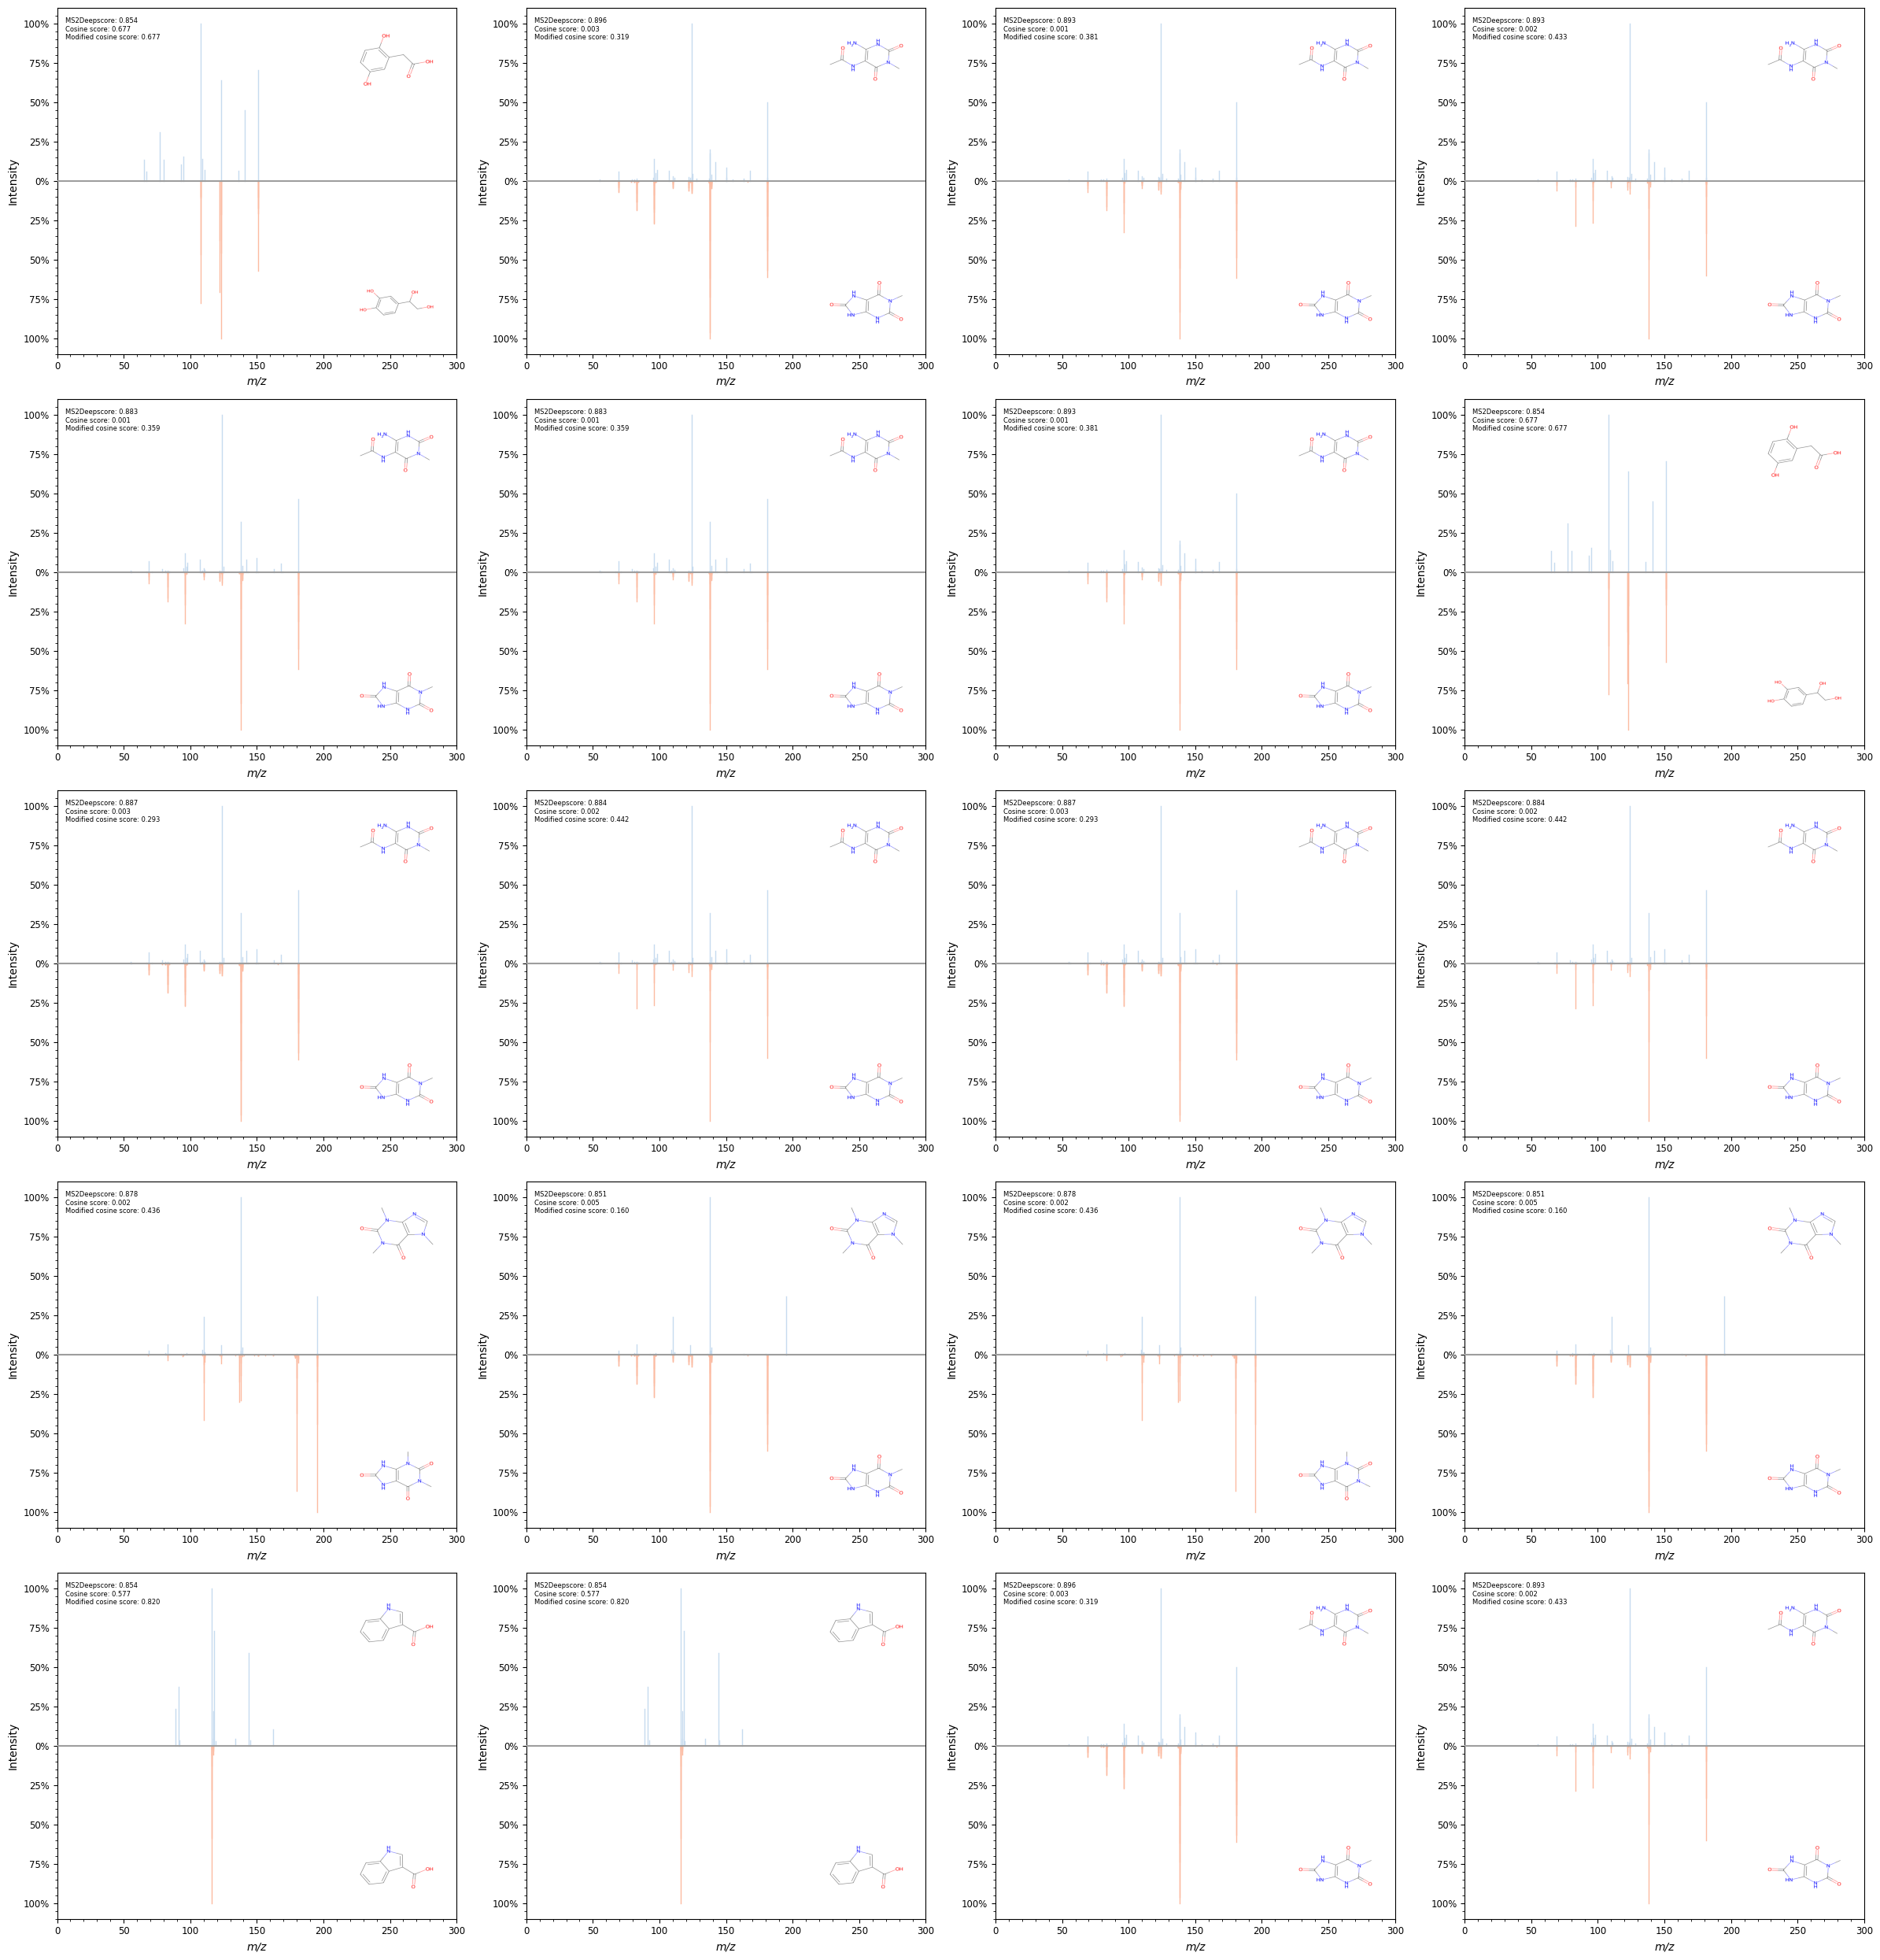

In [20]:
def select_smiles(spectrum_id):
    if spectrum_id not in manual_annotations.index:
        print(f"The spectrum id {spectrum_id} is not in the manual annotations")
        return None
    smiles = manual_annotations.loc[spectrum_id,"SMILES"]
    return smiles

plot_grid_of_plots(spectrum_pairs_with_manual_annotation)
plt.savefig("spectrum_plots_urine.svg", bbox_inches='tight')


# Show original plot in Figure 2

NameError: name 'manual_annotations' is not defined

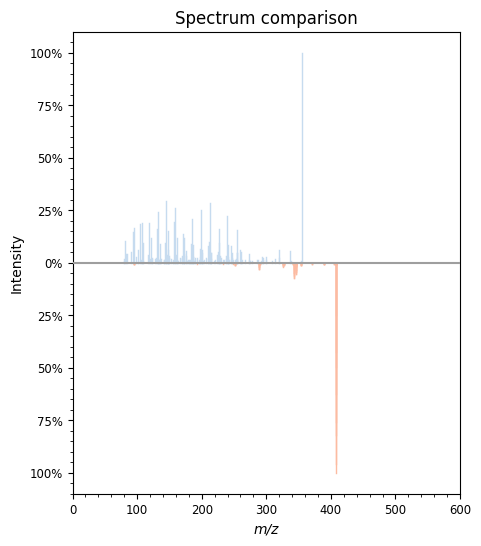

In [9]:
import matplotlib.pyplot as plt
def select_smiles(spectrum_id):
    if spectrum_id not in manual_annotations.index:
        print(f"The spectrum id {spectrum_id} is not in the manual annotations")
        return None
    smiles = manual_annotations.loc[spectrum_id,"SMILES"]
    return smiles
fig, ax = plt.subplots(figsize=(5, 6))

ax = plot_mirror_plot_with_structures(["neg_1231", "pos_761"], ax)
plt.show()


(<Figure size 1600x1200 with 1 Axes>, <Axes: xlabel='m/z', ylabel='Intensity'>)

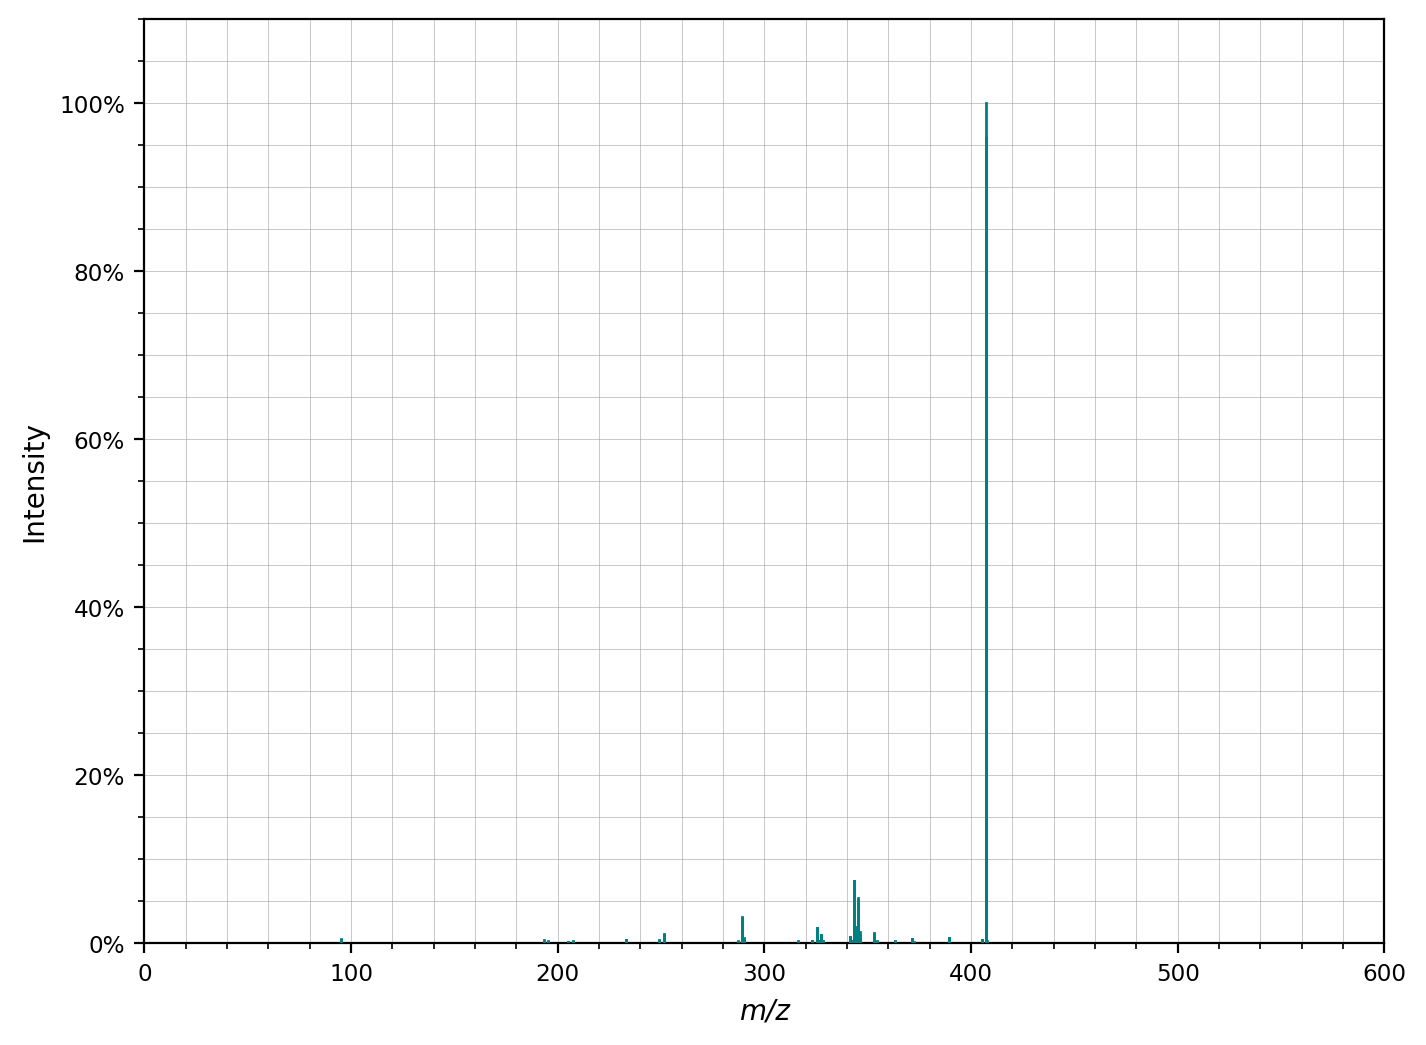

In [8]:
pos_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == "neg_1231"][0]
pos_spectrum.plot()

# Create embeddings and find interesting examples of likely cross ion mode exact matches
The matches are found based on MS2Query predictions and have not been confirmed with standards.

In [21]:
ms2ds_embeddings = ms2ds_model.get_embedding_array(spectra)


2909it [01:18, 36.98it/s]


In [22]:
import umap
import pandas as pd

reducer = umap.UMAP(random_state=42,  # this or whatever your favorite number is
                    n_neighbors=50 ,  # key parameters How global or local the distribution 30, 50
                    min_dist=0.2 , # can the dots overlap if you use 5 they move out a bit. 0.1, 0.2
                    )
reducer.fit(ms2ds_embeddings)
embedding_umap = reducer.transform(ms2ds_embeddings)
embedding_umap_df = pd.DataFrame(embedding_umap,
                                 index = [spectrum.get("query_spectrum_nr") for spectrum in spectra],
                                columns = ["x", "y"])
indexes = embedding_umap_df.index
embedding_umap_df["query_spectrum_nr"] = indexes

C:\Users\jonge094\AppData\Local\miniconda3\envs\pytorch\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
ms2query_annotations = pd.read_csv(ms2query_annotations_file_name)
merged_data = pd.merge(embedding_umap_df, ms2query_annotations, on="query_spectrum_nr", how= "outer")


In [24]:
# get all ms2query scores above 0.8
high_ms2query_score = merged_data[(merged_data['ms2query_model_prediction'] > 0.8)]
high_ms2query_score['precursor_mz_difference'].astype(float)
# and mass diff < 0.1 Da
high_ms2query_exact_matches = high_ms2query_score[(high_ms2query_score['precursor_mz_difference'].astype(float) < 0.1)]
# Get the cases that have at least 1 pos and 1 neg example
has_pos_and_neg = high_ms2query_exact_matches.groupby('inchikey')['ionmode'].apply(lambda x: {'positive', 'negative'}.issubset(set(x)))
result = high_ms2query_exact_matches[high_ms2query_exact_matches['inchikey'].isin(has_pos_and_neg[has_pos_and_neg].index)]

In [25]:
result.sort_values(by='inchikey')


,x,y,...,npc_pathway_results,ionmode
2824,11.270563,3.241034,...,Terpenoids,negative
1557,11.281293,3.043753,...,Terpenoids,positive
1493,11.299299,3.072606,...,Terpenoids,positive
1486,11.325418,3.083663,...,Terpenoids,positive
689,11.351658,3.077568,...,Terpenoids,positive
696,11.367012,3.111547,...,Terpenoids,positive
760,11.328959,3.108611,...,Terpenoids,positive
1950,11.846659,10.962747,...,Alkaloids,negative
970,9.270762,12.894511,...,Alkaloids,positive
173,9.221815,12.970866,...,Alkaloids,positive


In [26]:
# First, group by inchikey
grouped = result.groupby('inchikey')

# Store one pair per inchikey
ionmode_pairs = []

for inchikey, group in grouped:
    pos = group[group['ionmode'] == 'positive']
    neg = group[group['ionmode'] == 'negative']

    # Only proceed if both exist
    if not pos.empty and not neg.empty:
        pos_row = pos.iloc[0]
        neg_row = neg.iloc[0]
        ionmode_pairs.append((pos_row, neg_row))

In [27]:
# List of spectrum ID pairs
spectrum_id_pairs = [
    (pos['query_spectrum_nr'], neg['query_spectrum_nr'])
    for pos, neg in ionmode_pairs
]

In [28]:
spectrum_id_pairs

[('pos_690', 'neg_1231'),
 ('pos_174', 'neg_357'),
 ('pos_267', 'neg_434'),
 ('pos_729', 'neg_1139'),
 ('pos_203', 'neg_113'),
 ('pos_453', 'neg_52'),
 ('pos_326', 'neg_380'),
 ('pos_332', 'neg_269')]

In [29]:
# this is done to ensure we use the same smiles representation for pos and negative. To make it clearer they are exact matches.
inchikey_to_smiles = (
    result[['inchikey', 'smiles']]
    .dropna()
    .drop_duplicates(subset=['inchikey'])  # first occurrence per inchikey
    .set_index('inchikey')['smiles']
    .to_dict()
)

1it [00:00, 16.83it/s]
1it [00:00, 26.64it/s]
1it [00:00,  9.60it/s]
1it [00:00, 22.69it/s]
1it [00:00, 32.00it/s]
1it [00:00, 56.60it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.93it/s]
1it [00:00, 31.99it/s]
1it [00:00, 36.86it/s]
1it [00:00, 62.43it/s]
1it [00:00, 31.78it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.94it/s]
1it [00:00, 63.81it/s]
1it [00:00, 61.79it/s]


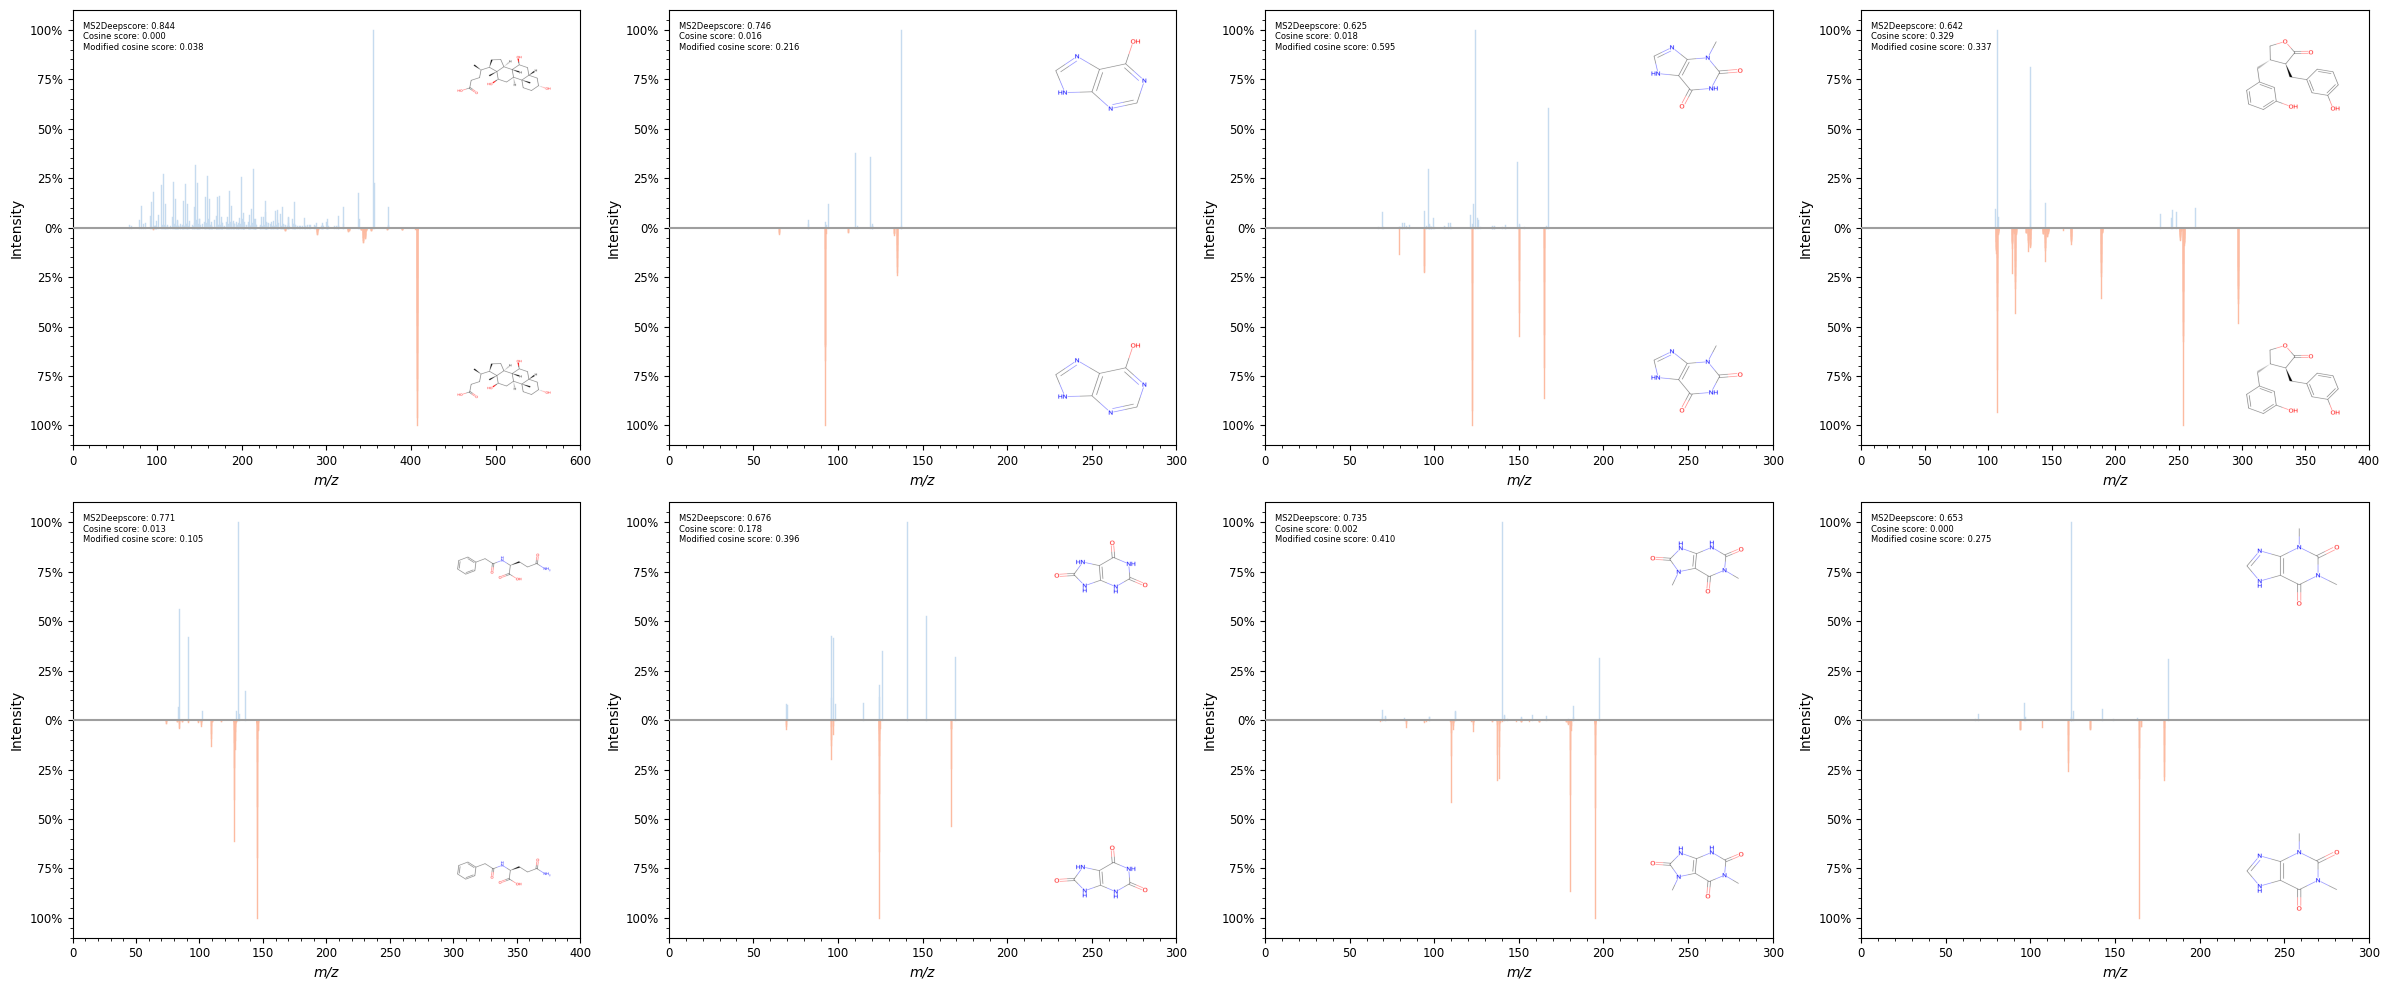

In [30]:
def select_smiles(spectrum_id):
    row = result[result['query_spectrum_nr'] == spectrum_id]
    if row.empty:
        return None
    inchikey = row.iloc[0]['inchikey']
    return inchikey_to_smiles.get(inchikey)
plot_grid_of_plots(spectrum_id_pairs)
plt.savefig("exact_matches_urine.svg", bbox_inches='tight')


# Examples for in presentation

In [110]:
from matchms.plotting.spectrum_plots import plot_spectra_mirror
from rdkit import Chem
import matchms.similarity as mssim
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit.Chem import Draw


def select_smiles(spectrum_id):
    row = result[result['query_spectrum_nr'] == spectrum_id]
    if row.empty:
        return None
    inchikey = row.iloc[0]['inchikey']
    return inchikey_to_smiles.get(inchikey)

def plot_mirror_plot_with_structures(spectrum_ids, ax):
    for spectrum_id in spectrum_ids:
        if spectrum_id[:3] == "pos":
            spectrum_id_pos = spectrum_id
        else:
            spectrum_id_neg = spectrum_id

    pos_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_pos][0]
    neg_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_neg][0]

    pos_spectrum.set("compound_name", "")
    neg_spectrum.set("compound_name", "")
    ax = plot_spectra_mirror(pos_spectrum, neg_spectrum, grid=False,
                              ax=ax,
                              # max_mz=420,
                              color_top = "#C6DBEF",
                              color_bottom="#FCBBA1",
                             )

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    smiles_pos = select_smiles(spectrum_id_pos)
    if smiles_pos:
        smiles_img_pos = Draw.MolToImage(Chem.MolFromSmiles(smiles_pos), size=(300, 300))
        x_pos = xmax - (xmax - xmin) * 0.2
        y_pos = ymax * 0.6
        imagebox = OffsetImage(smiles_img_pos, zoom=0.3)  # Adjust zoom as needed
        ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False, zorder=10)
        ax.add_artist(ab)

    smiles_neg = select_smiles(spectrum_id_neg)
    if smiles_neg:
        smiles_img_neg = Draw.MolToImage(Chem.MolFromSmiles(smiles_neg), size=(300, 300))
        # smiles_img_neg = ImageOps.mirror(smiles_img_neg)
        x_pos = xmax - (xmax - xmin) * 0.2
        y_pos = ymin * 0.6
        imagebox = OffsetImage(smiles_img_neg, zoom=0.3)  # Adjust zoom as needed
        ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False, zorder=10)
        ax.add_artist(ab)

    similarity_cosine = mssim.CosineGreedy(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    similarity_modified_cosine = mssim.ModifiedCosine(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    ms2deepscore_score = ms2ds_model.pair(pos_spectrum, neg_spectrum)
    ax.text(xmax - (xmax - xmin) * 0.98, 0.8,
            f"MS2Deepscore: {ms2deepscore_score:.3f}\n"
            f"Cosine score: {similarity_cosine['score']:.3f}\n"
            f"Modified cosine score: {similarity_modified_cosine['score']:.3f}"
            , fontsize=10)
    ax.set_title(None)
    return ax

1it [00:00,  7.05it/s]
1it [00:00, 21.12it/s]


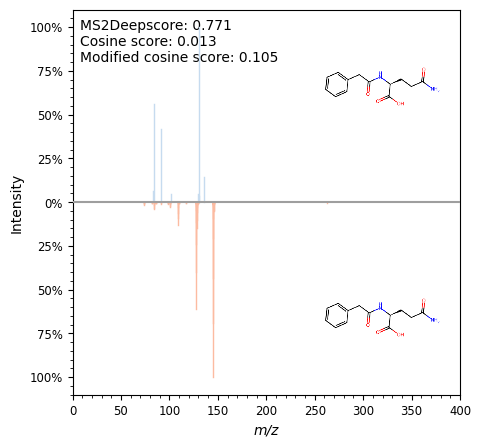

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax = plot_mirror_plot_with_structures(('pos_203', 'neg_113'), ax)
# plt.show()
plt.savefig("pos_neg_exact_match_ms2deepscore.png", dpi=600, bbox_inches='tight')



1it [00:00, 32.05it/s]
1it [00:00, 31.76it/s]


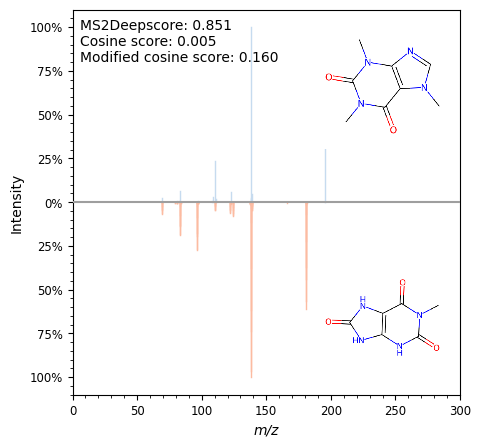

In [112]:
import matplotlib.pyplot as plt
def select_smiles(spectrum_id):
    if spectrum_id not in manual_annotations.index:
        print(f"The spectrum id {spectrum_id} is not in the manual annotations")
        return None
    smiles = manual_annotations.loc[spectrum_id,"SMILES"]
    return smiles

fig, ax = plt.subplots(figsize=(5, 5))

ax = plot_mirror_plot_with_structures(('pos_401', 'neg_316'), ax)
plt.savefig("pos_neg_analogue.png", dpi=600, bbox_inches='tight')


# plot pos pos example

In [77]:
from matchms.plotting.spectrum_plots import plot_spectra_mirror
from rdkit import Chem
import matchms.similarity as mssim
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit.Chem import Draw


def select_smiles(spectrum_id):
    if spectrum_id not in manual_annotations.index:
        print(f"The spectrum id {spectrum_id} is not in the manual annotations")
        return None
    smiles = manual_annotations.loc[spectrum_id,"SMILES"]
    return smiles

def plot_mirror_plot_with_structures(spectrum_ids, ax):
    spectrum_id_1 = spectrum_ids[0]
    spectrum_id_2 = spectrum_ids[1]

    pos_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_1][0]
    neg_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id_2][0]

    pos_spectrum.set("compound_name", "")
    neg_spectrum.set("compound_name", "")
    ax = plot_spectra_mirror(pos_spectrum, neg_spectrum, grid=False,
                              ax=ax,
                              # max_mz=420,
                              color_top = "#C6DBEF",
                              color_bottom="#C6DBEF"
                             )

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    smiles_pos = select_smiles(spectrum_id_1)
    if smiles_pos:
        smiles_img_pos = Draw.MolToImage(Chem.MolFromSmiles(smiles_pos), size=(300, 300))
        x_pos = xmax - (xmax - xmin) * 0.2
        y_pos = ymax * 0.6
        imagebox = OffsetImage(smiles_img_pos, zoom=0.3)  # Adjust zoom as needed
        ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False, zorder=10)
        ax.add_artist(ab)

    smiles_neg = select_smiles(spectrum_id_2)
    if smiles_neg:
        smiles_img_neg = Draw.MolToImage(Chem.MolFromSmiles(smiles_neg), size=(300, 300))
        # smiles_img_neg = ImageOps.mirror(smiles_img_neg)
        x_pos = xmax - (xmax - xmin) * 0.2
        y_pos = ymin * 0.6
        imagebox = OffsetImage(smiles_img_neg, zoom=0.3)  # Adjust zoom as needed
        ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False, zorder=10)
        ax.add_artist(ab)

    similarity_cosine = mssim.CosineGreedy(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    similarity_modified_cosine = mssim.ModifiedCosine(tolerance=0.01).pair(pos_spectrum, neg_spectrum)
    ms2deepscore_score = ms2ds_model.pair(pos_spectrum, neg_spectrum)
    ax.text(xmax - (xmax - xmin) * 0.98, 0.9,
            # f"MS2Deepscore: {ms2deepscore_score:.3f}\n"
            f"Cosine score: {similarity_cosine['score']:.3f}\n"
            f"Modified cosine score: {similarity_modified_cosine['score']:.3f}"
            , fontsize=10)
    ax.set_title(None)
    return ax

1it [00:00, 21.23it/s]
1it [00:00, 63.97it/s]


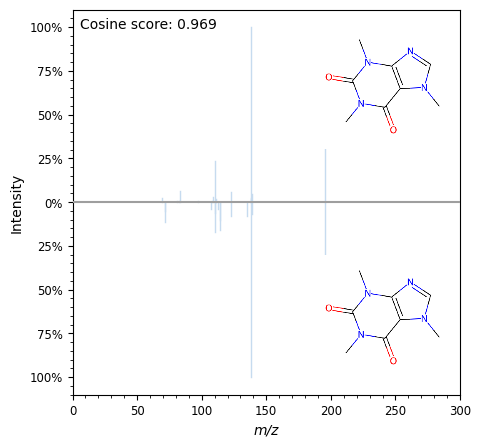

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax = plot_mirror_plot_with_structures(["pos_1198", "pos_1314"], ax)
# plt.show()
plt.savefig("pos_pos_caffeine.png", dpi=600, bbox_inches='tight')


1it [00:00, 27.13it/s]
1it [00:00, 31.99it/s]


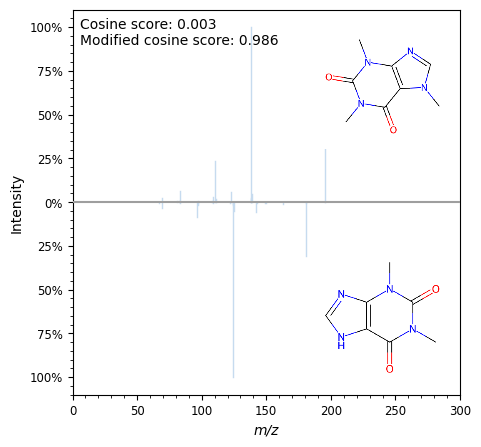

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax = plot_mirror_plot_with_structures(["pos_1198", "pos_1129"], ax)
plt.savefig("pos_pos_caffeine_theophiline.png", dpi=600, bbox_inches='tight')

